In [248]:
import os
import argparse
import csv
import numpy as np
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


from collections import defaultdict
from tqdm import tqdm

POS_PAIRS_FILENAME = "pos_pairs.csv"
NEG_PAIRS_FILENAME = "neg_pairs.csv"
HOTELS_FILENAME = "hotels.csv"

def read_pairs(path):
    pairs = []
    with open(path, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            int_row = [int(i) for i in row]
            pairs.append(int_row)

    return pairs

def read_hotels(path):
    hotels = []
    with open(path, 'r') as file:
        for row in file:
            hotels.append(int(row))

    return hotels

def convert_pairs_to_dict(pairs):
    a_dict = defaultdict(list)
    for p in pairs:
        a_dict[p[0]].append(p[1])
    return a_dict

def read_pairs(filename):
    pairs = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            int_row = [int(i) for i in row]
            pairs.append(int_row)
    return pairs

In [413]:
def similarity(e1, e2):
    dot_product = torch.sum(e1 * e2, dim=-1)
    prob = torch.sigmoid(dot_product)
    return prob

In [430]:
class EmbeddingModeler(nn.Module):

    def __init__(self, num_embeddings, embedding_dim, with_bias=True):
        super(EmbeddingModeler, self).__init__()
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, pair):
        input = self.embeddings(pair[:, 0])
        output = self.embeddings(pair[:, 1])
        return similarity(input, output)

    def pred_embed_id_pair(self, pair):
        input = self.embeddings(pair[:, 0])
        output = self.embeddings(pair[:, 1])
        return input, output

In [426]:
class HotelEmbeddingsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, pos_pairs='pos_pairs.csv', neg_pairs='neg_pairs.csv', hotels='hotels.csv'):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.pos_pairs = read_pairs(pos_pairs)
        self.neg_pairs = read_pairs(neg_pairs)
        self.hotels = read_hotels(hotels)

        self.p_dict = convert_pairs_to_dict(self.pos_pairs)
        self.n_dict = convert_pairs_to_dict(self.neg_pairs)

        self.positives = [self.p_dict[i] for i in self.hotels]
        self.negatives = [self.n_dict[i] for i in self.hotels] 

        self.hotel_embedding_mapping = {hotel: i for i, hotel in enumerate(self.hotels)}

        self.reference_indices = [self.hotel_embedding_mapping[u] for u in self.hotels]
        self.positives_indices = [[self.hotel_embedding_mapping[h] for h in u] for u in self.positives]
        self.negatives_indices = [[self.hotel_embedding_mapping[h] for h in u] for u in self.negatives]

        self.training_data = []
        for i in self.reference_indices:
            for p in self.positives_indices[i]:
                self.training_data.append([i, p, 1])
            for p in self.positives_indices[i]:
                self.training_data.append([i, p, 1])
            for n in self.negatives_indices[i]:
                self.training_data.append([i, n, 0])

    def __len__(self):
        return len(self.training_data)

    def __getitem__(self, idx):
        return torch.LongTensor(self.training_data[idx])

In [427]:
hotel_dataset = HotelEmbeddingsDataset()
dataset_loader = torch.utils.data.DataLoader(hotel_dataset,
                                             batch_size=BATCH_SIZE, shuffle=True)

In [428]:
hotels = read_hotels('hotels.csv')
print(N_HOTELS)

168829


In [454]:
BATCH_SIZE = 1024
EMBEDDING_DIM = 32
N_HOTELS = len(hotels)

# initialize embeddings randomly
model = EmbeddingModeler(N_HOTELS, EMBEDDING_DIM, with_bias=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
model.to(device)
print(device)

optimizer = torch.optim.Adagrad(model.parameters(), lr=1)
loss_func = nn.BCELoss()

best_loss = 9999

# loop over epochs
epoch_losses = []
patience = 0
for e in range(20):
    losses = 0
    for (idx, batch) in enumerate(dataset_loader):   
        batch = batch.to(device)    
        pred = model(batch)
        
        target = batch[:, 2]
        loss = loss_func(pred.float(), target.float())

        loss.backward()
        losses += loss.item()

        optimizer.step() # perform the backprop step
        optimizer.zero_grad() # reset loss to 0

    avg_loss = loss / len(dataset_loader.dataset)
    if e % 1 == 0:
        print(f"epoch: {e}: {avg_loss}")
    if best_loss > avg_loss:
        torch.save(model, './sad_embedding_model.p')
        best_loss = avg_loss
        patience = 0
    if patience > 2:
        break
    patience += 1
print(f"best loss: {best_loss}")

cuda
epoch: 0: 4.4496818674133465e-08
epoch: 1: 4.4193019022031876e-08
epoch: 2: 2.6651015616607765e-08
epoch: 3: 4.053019253547063e-08
epoch: 4: 2.010766486648663e-08
epoch: 5: 1.6728858298620253e-08
epoch: 6: 1.497006962836167e-08
epoch: 7: 1.834969864944469e-08
epoch: 8: 3.167990314523195e-08
epoch: 9: 1.5810838860375043e-08
epoch: 10: 3.371894408132903e-08
best loss: 1.497006962836167e-08


In [461]:
def embed_hotel_pair(samples):
    embed_samples = []
    for s in samples:
        embed_samples.append([hotel_dataset.hotel_embedding_mapping[s[0]],
                                hotel_dataset.hotel_embedding_mapping[s[1]]])
    return embed_samples

In [462]:
within_group = []
differing_group = []
model = torch.load('sad_embedding_model.p')
model.eval()

positive_samples = random.sample(hotel_dataset.pos_pairs, 100000)
negative_samples = random.sample(hotel_dataset.neg_pairs, 100000)

pos_embed_samples = embed_hotel_pair(positive_samples)
neg_embed_samples = embed_hotel_pair(negative_samples)

pos_embed_samples = torch.LongTensor(pos_embed_samples).to(device)    
pos_1, pos_2 = model.pred_embed_id_pair(pos_embed_samples)
wg = torch.mean(similarity(pos_1, pos_2))
print(wg)

neg_embed_samples = torch.LongTensor(neg_embed_samples).to(device)    
neg_1, neg_2 = model.pred_embed_id_pair(neg_embed_samples)
dg = torch.mean(similarity(neg_1, neg_2))
print(dg)

print(wg - dg)

tensor(0.9217, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1742, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7475, device='cuda:0', grad_fn=<SubBackward0>)


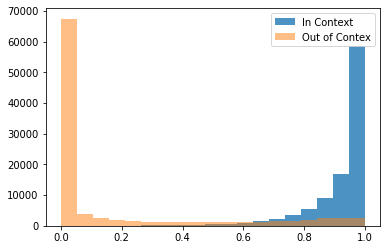

In [464]:
from matplotlib import pyplot
import numpy as np

bins = np.linspace(0, 1, 20)
pyplot.hist(similarity(pos_1, pos_2).detach().cpu().numpy(), bins, alpha=0.8, label='In Context')
pyplot.hist(similarity(neg_1, neg_2).detach().cpu().numpy(), bins, alpha=0.5, label='Out of Contex')
pyplot.legend(loc='upper right')
pyplot.show()

# Save Embeddings

In [465]:
list_hotels = hotel_dataset.hotels
list_embeddings = []

model.eval()
for hotel in tqdm(list_hotels):   
    hotel_embed_id = hotel_dataset.hotel_embedding_mapping[hotel]
    hotel_embed_id = torch.LongTensor([hotel_embed_id]).to(device)    
    embedding = model.embeddings(hotel_embed_id)
    list_embeddings.extend(embedding.detach().cpu().numpy())

100%|██████████| 168829/168829 [00:15<00:00, 11044.89it/s]


In [466]:
import pandas as pd 

embeddings = pd.DataFrame(
    {'hotel_id': list_hotels,
     'embedding': list_embeddings,
    })

In [467]:
embeddings.to_parquet('embeddings.parquet')

In [468]:
from google.colab import files
files.download('embeddings.parquet') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>